In [17]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
# Load my data to eur (minute by minute data)
eur = pd.read_csv("/Users/john/Desktop/eurv1.csv", parse_dates=['time'], index_col=['time'], 
                 usecols= ['OpenMid', 'HighMid', 'LowMid', 'CloseMid', 'lowBid','highAsk','volume', 'time'])

In [53]:
# Resample eur data to daily
eur1d = eur.resample('1D').agg({'OpenMid': 'first', 
                       'HighMid': 'max', 
                        'LowMid': 'min', 
                      'CloseMid': 'last',
                       'lowBid' : 'min',
                      'highAsk' : 'max',
                       'volume' : 'sum'})

In [54]:
eur1d.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='time', length=1339, freq='D')

In [55]:
# Create Volatility column, this is what i want to predict!
eur1d['Volatility'] = eur1d['highAsk'] - eur1d['lowBid']

# Dealing with NaN values

In [56]:
eur1d.fillna(method='ffill', inplace=True)
eur1d.head(3)

,OpenMid,HighMid,LowMid,CloseMid,lowBid,highAsk,volume,Volatility
time,,,,,,,,
2014-01-01,1.375250,1.377385,1.374245,1.376425,1.37353,1.37757,5106.0,0.00404
2014-01-02,1.376435,1.377565,1.362960,1.366535,1.36290,1.37769,102368.0,0.01479
2014-01-03,1.366535,1.367205,1.358250,1.358885,1.35818,1.36727,68106.0,0.00909


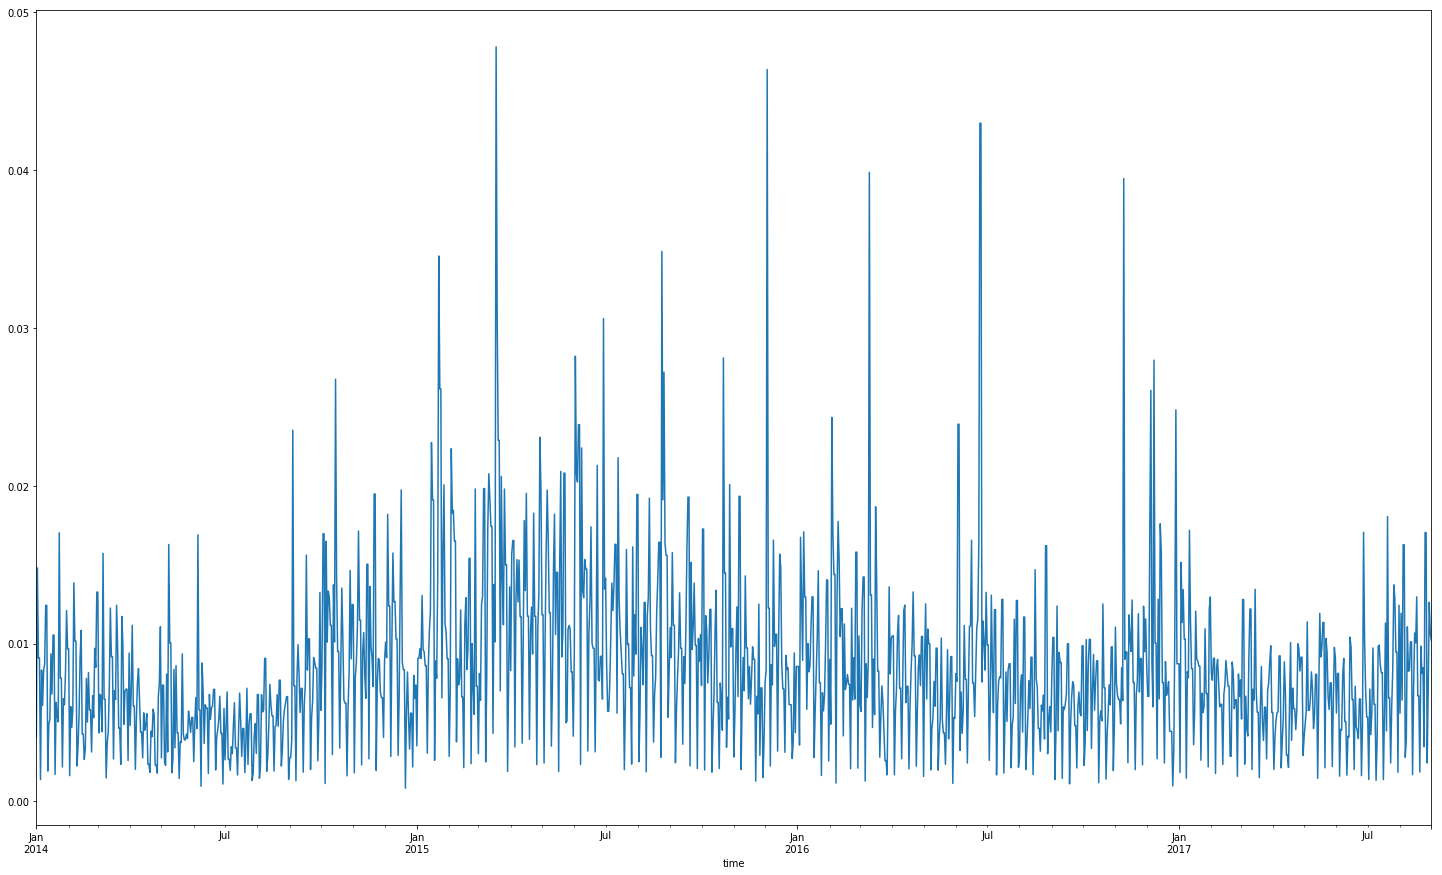

In [62]:
eur1d['Volatility'].plot(figsize=(25,15)) # Stationary data no need to differenciate

# Autocorrelation - not good, as i have stationary data

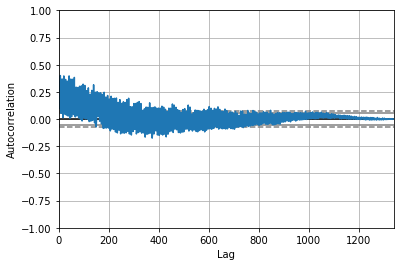

In [57]:
autocorrelation_plot(eur1d['Volatility'])

In [63]:
# very weak autocorrelation is expected as volatility is not trending unless big negative event or recession period.

print('Autocorrelation 1: ', eur1d['Volatility'].autocorr(1))
print('Autocorrelation 2: ', eur1d['Volatility'].autocorr(2))
print('Autocorrelation 3: ', eur1d['Volatility'].autocorr(3))
print('Autocorrelation 7: ', eur1d['Volatility'].autocorr(7))
print('Autocorrelation 20: ', eur1d['Volatility'].autocorr(20))
print('Autocorrelation 21: ', eur1d['Volatility'].autocorr(21))
print('Autocorrelation 22: ', eur1d['Volatility'].autocorr(22))

Autocorrelation 1:  0.343785423213
Autocorrelation 2:  0.192441222391
Autocorrelation 3:  0.100985931896
Autocorrelation 7:  0.401984203082
Autocorrelation 20:  0.18071749864
Autocorrelation 21:  0.400046161328
Autocorrelation 22:  0.127815697426


In [60]:
#  Split my data: Training 65% - Test 35%
n = len(eur1d['Volatility'])

train = eur1d['Volatility'][:int(.65*n)]
test = eur1d['Volatility'][int(.65*n):]

print ('Length of n:', n)
print ('Length of train:', len(train))
print ('Length of test:', len(test))

Length of n: 1339
Length of train: 870
Length of test: 469


# Daily ARIMA

In [61]:
model = sm.tsa.ARIMA(train, (1, 0, 1)).fit()

predictions = model.predict(
    '2016-05-20',
    '2017-08-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))

model.summary()

# Last table is broken...
# {AR.1 Real: 0.6238, AR.1 Imaginary: -0.7824j, AR.1 Modulus : 1.0006, AR.1 Frequency : -0.1429 } etc....

Mean absolute error:  0.00334050611778


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Volatility   No. Observations:                  870
Model:                     ARMA(1, 1)   Log Likelihood                3335.465
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 19 Oct 2017   AIC                          -6662.931
Time:                        21:08:06   BIC                          -6643.857
Sample:                    01-01-2014   HQIC                         -6655.633
                         - 05-19-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0089      0.001      8.667      0.000       0.007       0.011
ar.L1.Volatility     0.9853      0.013     76.753      0.000       0.960       1.010
ma.L1.Volatility    -0.9106      0.042    -21.734      0.000      -0.993      -0.828
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0150           +0.0000j            1.0150            0.0000
MA.1            1.0982           +0.0000j            1.0982            0.0000
-----------------------------------------------------------------------------
"""

In [64]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2016-05-20',
    '2017-08-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))

model.summary()

Mean absolute error:  0.00322144441865


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Volatility   No. Observations:                  870
Model:                     ARMA(2, 2)   Log Likelihood                3352.384
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 19 Oct 2017   AIC                          -6692.768
Time:                        21:14:41   BIC                          -6664.157
Sample:                    01-01-2014   HQIC                         -6681.821
                         - 05-19-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0086      0.001      6.092      0.000       0.006       0.011
ar.L1.Volatility     1.2591      0.112     11.217      0.000       1.039       1.479
ar.L2.Volatility    -0.2626      0.112     -2.355      0.019      -0.481      -0.044
ma.L1.Volatility    -1.0212      0.113     -9.037      0.000      -1.243      -0.800
ma.L2.Volatility     0.0546      0.107      0.510      0.610      -0.155       0.264
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0048           +0.0000j            1.0048            0.0000
AR.2            3.7891           +0.0000j            3.7891            0.0000
MA.1            1.0367           +0.0000j            1.0367            0.0000
MA.2           17.6515           +0.0000j           17.6515            0.0000
-----------------------------------------------------------------------------
"""

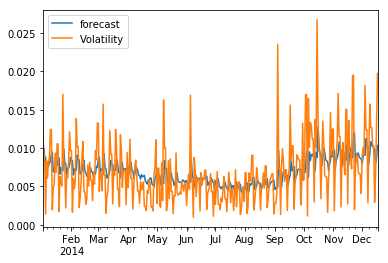

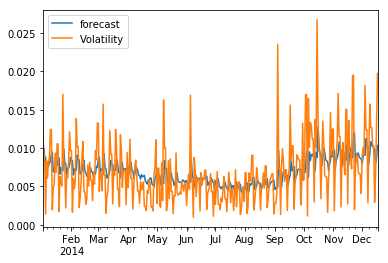

In [65]:
model.plot_predict(1, 350)

In [30]:
model = sm.tsa.ARIMA(train, (1, 1, 1)).fit()

predictions = model.predict(
    '2016-05-20',
    '2017-08-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))

model.summary()

Mean absolute error:  0.00770648599037


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Volatility   No. Observations:                  869
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3346.521
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 19 Oct 2017   AIC                          -6685.042
Time:                        21:04:27   BIC                          -6665.973
Sample:                    01-02-2014   HQIC                         -6677.745
                         - 05-19-2016                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.123e-07   7.56e-06      0.055      0.957   -1.44e-05    1.52e-05
ar.L1.D.Volatility     0.2098      0.035      6.054      0.000       0.142       0.278
ma.L1.D.Volatility    -0.9669      0.009   -112.846      0.000      -0.984      -0.950
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.7661           +0.0000j            4.7661            0.0000
MA.1            1.0342           +0.0000j            1.0342            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
model = sm.tsa.ARIMA(train, (2, 1, 2)).fit()

predictions = model.predict(
    '2016-05-20',
    '2017-08-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))

model.summary()

Mean absolute error:  0.00770660701619


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Volatility   No. Observations:                  869
Model:                 ARIMA(2, 1, 2)   Log Likelihood                3347.228
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 19 Oct 2017   AIC                          -6682.456
Time:                        21:04:42   BIC                          -6653.852
Sample:                    01-02-2014   HQIC                         -6671.511
                         - 05-19-2016                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.512e-07   7.93e-06      0.044      0.965   -1.52e-05    1.59e-05
ar.L1.D.Volatility    -0.4095      0.324     -1.263      0.207      -1.045       0.226
ar.L2.D.Volatility     0.1581      0.041      3.901      0.000       0.079       0.238
ma.L1.D.Volatility    -0.3536      0.329     -1.074      0.283      -0.999       0.292
ma.L2.D.Volatility    -0.5914      0.314     -1.882      0.060      -1.207       0.024
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5339           +0.0000j            1.5339            0.5000
AR.2            4.1239           +0.0000j            4.1239            0.0000
MA.1            1.0353           +0.0000j            1.0353            0.0000
MA.2           -1.6333           +0.0000j            1.6333            0.5000
-----------------------------------------------------------------------------
"""

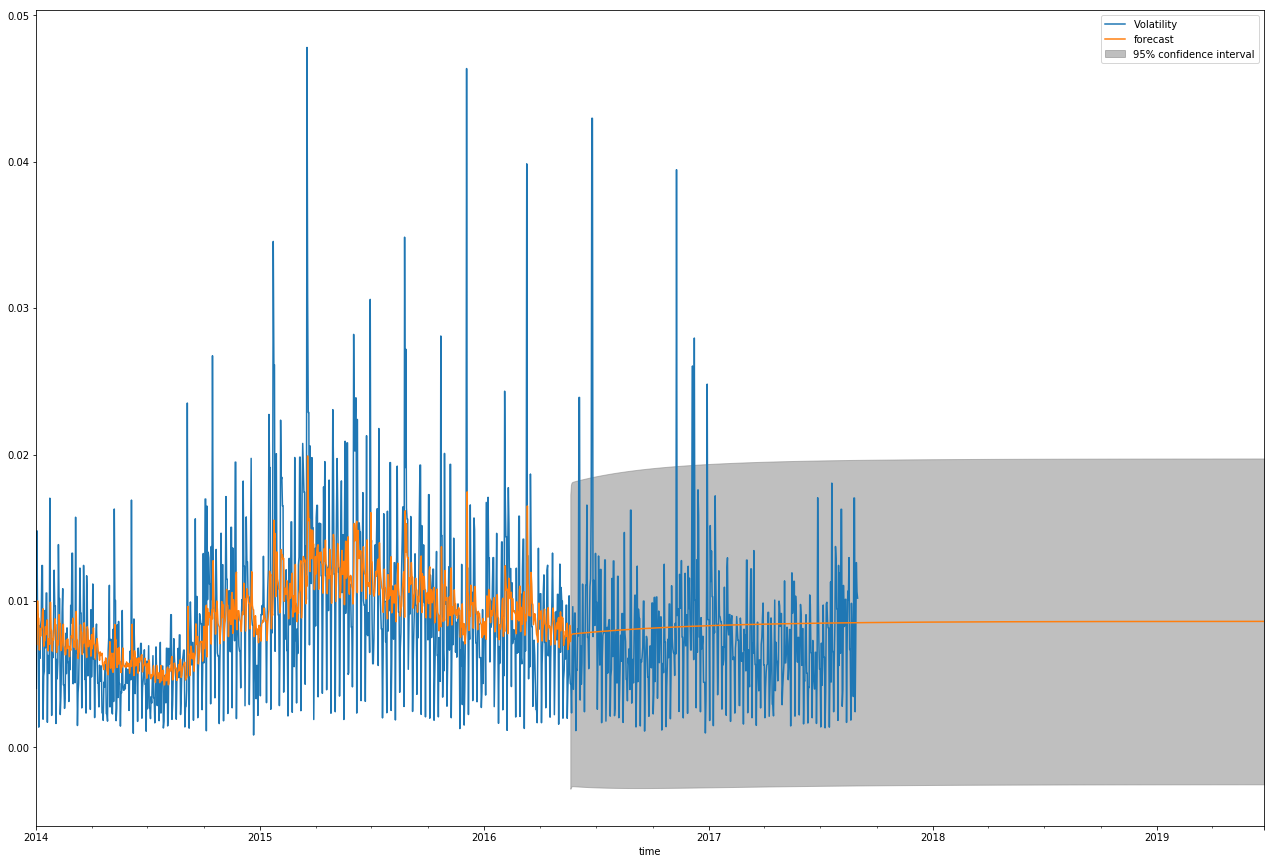

In [68]:
fig, ax = plt.subplots()
ax = eur1d['Volatility'].plot(ax=ax, figsize=(22,15))

fig = model.plot_predict(1, 2000, ax=ax, plot_insample=False)